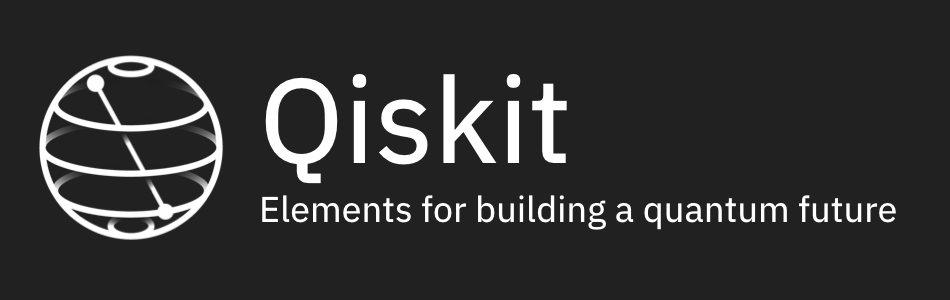

# Quantum Process Tomography

* **Last Updated:** June 17, 2019
* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2

This notebook contains examples for using the ``ignis.verification.tomography`` process tomography module.

In [1]:
# Needed for functions
import numpy as np
import time

# Import QISKit classes
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, Aer
from qiskit.quantum_info import state_fidelity, process_fidelity
from qiskit.tools.qi.qi import outer

# Tomography functions
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter

## 1-qubit process tomography example

In [2]:
# Process tomography of a Hadamard gate
q = QuantumRegister(1)
circ = QuantumCircuit(q)
circ.h(q[0])

# Run circuit on unitary simulator to find ideal unitary
job = qiskit.execute(circ, Aer.get_backend('unitary_simulator'))
ideal_unitary = job.result().get_unitary(circ)
# convert to Choi-matrix in column-major convention
choi_ideal = outer(ideal_unitary.ravel(order='F'))

# Generate process tomography circuits and run on qasm simulator
qpt_circs = process_tomography_circuits(circ, q)
job = qiskit.execute(qpt_circs, Aer.get_backend('qasm_simulator'), shots=4000)

# Extract tomography data so that counts are indexed by measurement configuration
qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)
qpt_tomo.data

{(('Zp',), ('X',)): {'0': 4000},
 (('Zp',), ('Y',)): {'1': 2005, '0': 1995},
 (('Zp',), ('Z',)): {'1': 2034, '0': 1966},
 (('Zm',), ('X',)): {'1': 4000},
 (('Zm',), ('Y',)): {'1': 1995, '0': 2005},
 (('Zm',), ('Z',)): {'1': 1959, '0': 2041},
 (('Xp',), ('X',)): {'1': 1938, '0': 2062},
 (('Xp',), ('Y',)): {'1': 1945, '0': 2055},
 (('Xp',), ('Z',)): {'0': 4000},
 (('Yp',), ('X',)): {'1': 2007, '0': 1993},
 (('Yp',), ('Y',)): {'1': 4000},
 (('Yp',), ('Z',)): {'1': 1939, '0': 2061}}

In [3]:
# MLE Least-Squares tomographic reconstruction
t = time.time()
choi_lstsq = qpt_tomo.fit(method='lstsq')
print('Least-Sq Fitter')
print('fit time:', time.time() - t)
print('fit fidelity (state):', state_fidelity(choi_ideal / 2, choi_lstsq.data / 2))
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))


# CVXOPT Semidefinite-Program tomographic reconstruction
t = time.time()
choi_cvx = qpt_tomo.fit(method='cvx')
print('\nCVXOPT Fitter')
print('fit time:', time.time() - t)
print('fit fidelity (state):', state_fidelity(choi_ideal / 2, choi_cvx.data / 2))
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_cvx.data, require_cptp=False)))


Least-Sq Fitter
fit time: 0.008728981018066406
fit fidelity (state): 0.998101347911632
fit fidelity (process): 0.99620629934705

CVXOPT Fitter
fit time: 0.03952598571777344
fit fidelity (state): 0.9998300598697589
fit fidelity (process): 0.9996601486134205


## 1-qubit process tomography of two-qubit swap gate

We will prepare qubit-0 and measure qubit-1 so the reconstructed channel should be an identity.

In [4]:
# Process tomography of a Hadamard gate
q = QuantumRegister(2)
circ = QuantumCircuit(q)
circ.swap(q[0], q[1])

# Ideal channel is a unitary
ideal_unitary = np.eye(2)
choi_ideal = outer(ideal_unitary.ravel(order='F'))

# Generate process tomography circuits and run on qasm simulator
# We use the optional prepared_qubits kwarg to specify that the prepared qubit was different to measured qubit
qpt_circs = process_tomography_circuits(circ, q[1], prepared_qubits=q[0])
job = qiskit.execute(qpt_circs, Aer.get_backend('qasm_simulator'), shots=2000)

# Extract tomography data so that counts are indexed by measurement configuration
qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)
qpt_tomo.data

{(('Zp',), ('X',)): {'1': 1011, '0': 989},
 (('Zp',), ('Y',)): {'1': 969, '0': 1031},
 (('Zp',), ('Z',)): {'0': 2000},
 (('Zm',), ('X',)): {'1': 993, '0': 1007},
 (('Zm',), ('Y',)): {'1': 1024, '0': 976},
 (('Zm',), ('Z',)): {'1': 2000},
 (('Xp',), ('X',)): {'0': 2000},
 (('Xp',), ('Y',)): {'1': 1030, '0': 970},
 (('Xp',), ('Z',)): {'1': 980, '0': 1020},
 (('Yp',), ('X',)): {'1': 1015, '0': 985},
 (('Yp',), ('Y',)): {'0': 2000},
 (('Yp',), ('Z',)): {'1': 978, '0': 1022}}

In [5]:
# Least-Squares tomographic reconstruction
t = time.time()
choi_lstsq = qpt_tomo.fit(method='lstsq')
print('Least-Sq Fitter')
print('fit time:', time.time() - t)
print('fit fidelity (state):', state_fidelity(choi_ideal / 2, choi_lstsq.data / 2))
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))

# CVXOPT Semidefinite-Program tomographic reconstruction
t = time.time()
choi_cvx = qpt_tomo.fit(method='cvx')
print('\nCVXOPT Fitter')
print('fit time:', time.time() - t)
print('fit fidelity (state):', state_fidelity(choi_ideal / 2, choi_cvx.data / 2))
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_cvx.data, require_cptp=False)))

Least-Sq Fitter
fit time: 0.005930900573730469
fit fidelity (state): 0.992115841465833
fit fidelity (process): 0.9842938428874608

CVXOPT Fitter
fit time: 0.03724503517150879
fit fidelity (state): 0.9999284006090936
fit fidelity (process): 0.9998568063446612


## 2-Qubit entangling circuit

In [6]:
# Bell-state entangling circuit
q = QuantumRegister(2)
circ = QuantumCircuit(q)
circ.h(q[0])
circ.cx(q[0], q[1])

# Run circuit on unitary simulator to find ideal unitary
job = qiskit.execute(circ, Aer.get_backend('unitary_simulator'))
ideal_unitary = job.result().get_unitary(circ)
# convert to Choi-matrix in column-major convention
choi_ideal = outer(ideal_unitary.ravel(order='F'))

# Generate process tomography circuits and run on qasm simulator
qpt_circs = process_tomography_circuits(circ, q)
job = qiskit.execute(qpt_circs, Aer.get_backend('qasm_simulator'), shots=2000)

# Extract tomography data so that counts are indexed by measurement configuration
qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)

t = time.time()
choi_lstsq = qpt_tomo.fit(method='lstsq')
print('Least-Sq Fitter')
print('fit time:', time.time() - t)
print('fit fidelity (state):', state_fidelity(choi_ideal / 4, choi_lstsq.data / 4))
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))

t = time.time()
choi_cvx = qpt_tomo.fit(method='cvx')
print('\nCVXOPT Fitter')
print('fit time:', time.time() - t)
print('fit fidelity (state):', state_fidelity(choi_ideal / 4, choi_cvx.data / 4))
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_cvx.data, require_cptp=False)))

Least-Sq Fitter
fit time: 0.09495401382446289
fit fidelity (state): 0.9851755153211967
fit fidelity (process): 0.9705707953743966

CVXOPT Fitter
fit time: 0.9278693199157715
fit fidelity (state): 0.999898362918484
fit fidelity (process): 0.9997967361255218


## Using SIC-POVM preparation basis

In [7]:
# Process tomography of a Hadamard gate
q = QuantumRegister(1)
circ = QuantumCircuit(q)
circ.h(q[0])

# Run circuit on unitary simulator to find ideal unitary
job = qiskit.execute(circ, Aer.get_backend('unitary_simulator'))
ideal_unitary = job.result().get_unitary(circ)
# convert to Choi-matrix in column-major convention
choi_ideal = outer(ideal_unitary.ravel(order='F'))

# Generate process tomography circuits and run on qasm simulator
qpt_circs = process_tomography_circuits(circ, q, prep_labels='SIC', prep_basis='SIC')
job = qiskit.execute(qpt_circs, Aer.get_backend('qasm_simulator'), shots=2000)

# Extract tomography data so that counts are indexed by measurement configuration
qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs, prep_basis='SIC')
qpt_tomo.data

{(('S0',), ('X',)): {'0': 2000},
 (('S0',), ('Y',)): {'1': 996, '0': 1004},
 (('S0',), ('Z',)): {'1': 1020, '0': 980},
 (('S1',), ('X',)): {'1': 1355, '0': 645},
 (('S1',), ('Y',)): {'1': 995, '0': 1005},
 (('S1',), ('Z',)): {'1': 54, '0': 1946},
 (('S2',), ('X',)): {'1': 1349, '0': 651},
 (('S2',), ('Y',)): {'1': 182, '0': 1818},
 (('S2',), ('Z',)): {'1': 1460, '0': 540},
 (('S3',), ('X',)): {'1': 1368, '0': 632},
 (('S3',), ('Y',)): {'1': 1811, '0': 189},
 (('S3',), ('Z',)): {'1': 1481, '0': 519}}

In [8]:
# MLE Least-Squares tomographic reconstruction
t = time.time()
choi_lstsq = qpt_tomo.fit(method='lstsq')
print('Least-Sq Fitter')
print('fit time:', time.time() - t)
print('fit fidelity (state):', state_fidelity(choi_ideal / 2, choi_lstsq.data / 2))
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))

# CVXOPT Semidefinite-Program tomographic reconstruction
t = time.time()
choi_cvx = qpt_tomo.fit(method='cvx')

print('\nCVXOPT Fitter')
print('fit time:', time.time() - t)
print('fit fidelity (state):', state_fidelity(choi_ideal / 2, choi_cvx.data / 2))
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_cvx.data, require_cptp=False)))

Least-Sq Fitter
fit time: 0.007868051528930664
fit fidelity (state): 0.9985398816691363
fit fidelity (process): 0.9970818947829703

CVXOPT Fitter
fit time: 0.0404360294342041
fit fidelity (state): 0.9996813848252835
fit fidelity (process): 0.9993628708173398


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright